In [1]:
import datetime
import gc
import math
import matplotlib.pyplot as plt
import numpy as np
import open3d as o3
import os

from functools import partial
from fastai.vision import Path
from sklearn.model_selection import train_test_split
from math import sin, cos, acos, pi
from mpl_toolkits.mplot3d import Axes3D
from pprint import pprint

In [2]:
clip180 = partial(np.clip, a_min=-3.14, a_max=3.14)
clip90 = partial(np.clip, a_min=0., a_max=1.57)

In [3]:
def getCore(data):
    coreTmp = np.zeros((1, 3))
    coreTmp[:, 0] = np.sum(data[:, ::3], axis=1) / (data.shape[1] / 3)   #coreX
    coreTmp[:, 1] = np.sum(data[:, 1::3], axis=1) / (data.shape[1] / 3)  #coreY
    coreTmp[:, 2] = np.sum(data[:, 2::3], axis=1) / (data.shape[1] / 3)  #coreZ

    return coreTmp


def dataShift(data, core):    #使全部點剛好在第一象限
    data[:, ::3] = data[:, ::3] - core[0, 0]
    data[:, 1::3] = data[:, 1::3] - core[0, 1]
    data[:, 2::3] = data[:, 2::3] - core[0, 2]

    xShiftTmp = min(data[0, ::3])
    yShiftTmp = min(data[0, 1::3])
    zShiftTmp = min(data[0, 2::3])

    data[:, ::3] = data[:, ::3] - xShiftTmp
    data[:, 1::3] = data[:, 1::3] - yShiftTmp
    data[:, 2::3] = data[:, 2::3] - zShiftTmp

    return data


def getMaxRadius(data):
    maxTmp = 0
    indexTmp = 0

    for i in range(data.shape[1] // 3):
        tmp = np.sqrt(np.square(data[0, i*3]) + np.square(data[0, i*3 + 1]) + np.square(data[0, i*3 + 2]))
        if (tmp  > maxTmp):
            maxTmp = tmp
            indexTmp = i    

    return indexTmp, maxTmp


def getAABBSize(rdata):  
    xTmp = rdata[0, ::3]
    yTmp = rdata[0, 1::3]
    zTmp = rdata[0, 2::3]

    xDis = max(xTmp) - min(xTmp)
    yDis = max(yTmp) - min(yTmp)
    zDis = max(zTmp) - min(zTmp) 

    return xDis, yDis, zDis


def get3DMatrix(xDis, yDis, zDis, rData):
    MCount = np.zeros((mSize, mSize, mSize))
    MCount = MCount + 1e-7    #避免除零    
    MResult = np.zeros((mSize, mSize, mSize * 3))    #三通道
    MXSum = np.zeros((mSize, mSize, mSize))
    MYSum = np.zeros((mSize, mSize, mSize))
    MZSum = np.zeros((mSize, mSize, mSize))

    for i in range (rData.shape[1] // 3):
        D1Tmp = math.floor(rData[0, i*3] / xDis * mSize)
        D2Tmp = math.floor(rData[0, i*3 + 1] / yDis * mSize)
        D3Tmp = math.floor(rData[0, i*3 + 2] / zDis * mSize)
        
        D1Tmp = np.minimum(12, D1Tmp)
        D2Tmp = np.minimum(12, D2Tmp)
        D3Tmp = np.minimum(12, D3Tmp)
        
        D1Tmp = np.maximum(-12, D1Tmp)
        D2Tmp = np.maximum(-12, D2Tmp)
        D3Tmp = np.maximum(-12, D3Tmp)

        if D1Tmp != mSize and D2Tmp != mSize and D3Tmp != mSize:
            MCount[D1Tmp, D2Tmp, D3Tmp] = MCount[D1Tmp, D2Tmp, D3Tmp] + 1
            MXSum[D1Tmp, D2Tmp, D3Tmp] = MXSum[D1Tmp, D2Tmp, D3Tmp] + rData[0, i*3]
            MYSum[D1Tmp, D2Tmp, D3Tmp] = MYSum[D1Tmp, D2Tmp, D3Tmp] + rData[0, i*3 + 1]
            MZSum[D1Tmp, D2Tmp, D3Tmp] = MZSum[D1Tmp, D2Tmp, D3Tmp] + rData[0, i*3 + 2]
        else:
            D1Tmp = D1Tmp - 1 if D1Tmp == mSize else D1Tmp
            D2Tmp = D2Tmp - 1 if D2Tmp == mSize else D2Tmp
            D3Tmp = D3Tmp - 1 if D3Tmp == mSize else D3Tmp

            MCount[D1Tmp, D2Tmp, D3Tmp] = MCount[D1Tmp, D2Tmp, D3Tmp] + 1
            MXSum[D1Tmp, D2Tmp, D3Tmp] = MXSum[D1Tmp, D2Tmp, D3Tmp] + rData[0, i*3]
            MYSum[D1Tmp, D2Tmp, D3Tmp] = MYSum[D1Tmp, D2Tmp, D3Tmp] + rData[0, i*3 + 1]
            MZSum[D1Tmp, D2Tmp, D3Tmp] = MZSum[D1Tmp, D2Tmp, D3Tmp] + rData[0, i*3 + 2]
            
    MXSum = np.divide(MXSum, MCount)
    MYSum = np.divide(MYSum, MCount)
    MZSum = np.divide(MZSum, MCount)

    for i in range(mSize):
        MResult[:, :, i * 3] = MXSum[:, :, i]
        MResult[:, :, i * 3 + 1] = MYSum[:, :, i]
        MResult[:, :, i * 3 + 2] = MZSum[:, :, i]

    return MResult    

def q_norm(q):
    return np.sum(np.square(q))


def q_inv(q):
    invq = np.array([-q[0], -q[1], -q[2], q[3]]) / q_norm(q)
    return invq


def q_mut(q1, q2):
    assert len(q1) == 4 == len(q2)
    a1, b1, c1, d1 = q1
    a2, b2, c2, d2 = q2
    
    qw = (a1 * a2 - b1 * b2 - c1 * c2 - d1 * d2)
    qx = (a1 * b2 + b1 * a2 + c1 * d2 - d1 * c2)
    qy = (a1 * c2 - b1 * d2 + c1 * a2 + d1 * b2)
    qz = (a1 * d2 + b1 * c2 - c1 * b2 + d1 * a2)
    
    return np.array([qw, qx, qy, qz])

def rotate_with_q(xyz, q):
    xyz_tmp = np.append(xyz, 0)
    q_tmp = q_mut(q, q_mut(xyz_tmp, q_inv(q)))
    return q_tmp[:3]

def eva_rms(pred, tar):
    pred_tmp = pred.reshape(-1)
    tar_tmp = tar.reshape(-1)
    assert pred_tmp.shape == tar_tmp.shape

    return np.sqrt(np.mean((pred_tmp - tar_tmp)**2))

def show_pcd_3d(x_data, save=False, name=None):
    fig = plt.figure(figsize=(12, 12))
    index = np.arange(len(x_data))
    np.random.shuffle(index)
    index = index[:9]
    for i, idx in enumerate(index):
        data = x_data[idx].reshape(-1, 3)
        x = data[:, 0]
        y = data[:, 1]
        z = data[:, 2]

        ax = fig.add_subplot(3, 3, i + 1, projection='3d')
        ax.scatter(x, y, z, c='r', marker='o')
        ax.set_title(idx)
    if save:
        if not Path('results').exists():
            Path('results').mkdir()
        plt.savefig(f'results/{name}_pcd.png')


def show_match_result(pred, tar, save=False, name=None):
    '''
    pcd shape must have dimension of number of pcd, 
    like (num, x, x, x, 3), (num, -1), (num, -1, 3)
    '''
    assert len(pred) == len(tar)
    fig = plt.figure(figsize=(12, 12))
    index = np.arange(len(tar))
    np.random.shuffle(index)
    index = index[:9]
    for i, idx in enumerate(index):
        data = tar[idx].reshape(-1, 3)
        x = data[:, 0]
        y = data[:, 1]
        z = data[:, 2]

        ax = fig.add_subplot(3, 3, i + 1, projection='3d')
        ax.scatter(x, y, z, c='r', marker='o')

        data = pred[idx].reshape(-1, 3)
        x = data[:, 0]
        y = data[:, 1]
        z = data[:, 2]
        ax.scatter(x, y, z, c='b', marker='o')

        ax.set_title(f'index: {idx}, RMS: {eva_rms(pred[idx], tar[idx]):.2f}')
    if save:
        if not Path('results').exists():
            Path('results').mkdir()
        plt.savefig(f'results/{name}_match_result.png')

def scalar_reduction(x_hat, x_max, x_min):
    reduction = x_hat * (x_max - x_min) + x_min
    return np.float32(reduction)

def get_files_names(path):
    fnames=[]
    for idx, name in enumerate(path.ls()):
        if name.suffix == '.pcd':
            fnames.append(name)
    return fnames



In [4]:
def min_max_center(pcd):
    x_center = (np.max(whole_pcd[:, 0]) + np.min(whole_pcd[:, 0]))/2
    y_center = (np.max(whole_pcd[:, 1]) + np.min(whole_pcd[:, 1]))/2 
    z_center = (np.max(whole_pcd[:, 2]) + np.min(whole_pcd[:, 2]))/2 
    return x_center, y_center, z_center

In [5]:
def sum_center(pcd):
    x_center = 0
    y_center = 0
    z_center = 0

    for i in range(whole_pcd.shape[0]):
        x_center += whole_pcd[i, 0]
        y_center += whole_pcd[i, 1]
        z_center += whole_pcd[i, 2]

    x_center /= whole_pcd.shape[0]
    y_center /= whole_pcd.shape[0]
    z_center /= whole_pcd.shape[0]

    return x_center, y_center, z_center

## load data

In [6]:
load_pcd = o3.read_point_cloud("data/ori/bunny/bunny.ply", "ply")
down_pcd = o3.voxel_down_sample(load_pcd, voxel_size = 0.005) #
# down_pcd = load_pcd

In [7]:
ori_pcd = np.asarray(load_pcd.points)
whole_pcd = np.asarray(down_pcd.points)

In [8]:
ori_pcd.shape, whole_pcd.shape

((35947, 3), (3023, 3))

In [9]:
o3.visualization.draw_geometries([load_pcd])
o3.visualization.draw_geometries([down_pcd])

In [10]:
min_max_center_x, min_max_center_y, min_max_center_z =min_max_center(whole_pcd)
sum_center_x , sum_center_y, sum_center_z = sum_center(whole_pcd)

In [11]:
min_max_center_x, min_max_center_y, min_max_center_z

(-0.016801513333333337, 0.11003305865384616, -0.001288046470588236)

In [12]:
sum_center_x, sum_center_y, sum_center_z

(-0.026566374495957352, 0.0945661865887787, 0.008171725517656818)

## Modified center to (0, 0, 0)

In [13]:
whole_pcd[:,0] = whole_pcd[:,0] - min_max_center_x
whole_pcd[:,1] = whole_pcd[:,1] - min_max_center_y
whole_pcd[:,2] = whole_pcd[:,2] - min_max_center_z

In [14]:
print(min_max_center(whole_pcd))

(0.0, 6.938893903907228e-18, 0.0)


In [15]:
frame = np.array([[3, 0, 0], [0, 6, 0], [0, 0, 9]])

In [16]:
frame.shape, whole_pcd.shape

((3, 3), (3023, 3))

In [17]:
frame

array([[3, 0, 0],
       [0, 6, 0],
       [0, 0, 9]])

In [18]:
whole_pcd

array([[ 0.042184,  0.012627,  0.024295],
       [ 0.059519, -0.039505, -0.0025  ],
       [-0.040428,  0.045383,  0.015866],
       [-0.027776,  0.019096,  0.004121],
       ...,
       [-0.049709,  0.039876, -0.03414 ],
       [-0.011648,  0.045797, -0.00715 ],
       [-0.020653,  0.045356, -0.008465],
       [-0.024091,  0.040152, -0.003608]])

In [19]:
TRAIN_QUANTITY = 1
TEST_QUANTITY = 1
mSize = 12

In [20]:
starttime = datetime.datetime.now()

data = whole_pcd
frame = frame

train_raw = []
test_raw = []
labeltr_raw = []
labelte_raw = []

for i in range(TRAIN_QUANTITY + TEST_QUANTITY):
    q = np.random.uniform(0., 1., (3))        
    q = np.append(q, 0.)

    labels = np.zeros(frame.shape)
    
    rotateData = np.zeros(data.shape)

    for n in range(data.shape[0]):
        rotateData[n] = rotate_with_q(data[n], q)

    for t in range(frame.shape[0]):
        labels[t] = rotate_with_q(frame[t], q)

    rotateData = rotateData.reshape(1, -1)
    labels = labels.reshape(9)

    dis = getAABBSize(rotateData)
    result = get3DMatrix(dis[0], dis[1], dis[2], rotateData).reshape(-1)
    
    tmp1 = result
    tmp2 = labels

    if i % 200 == 0:
        endtime = datetime.datetime.now()
        print("item %d execute time: %s" % (i, endtime - starttime))

    
    if i < TRAIN_QUANTITY:
        train_raw.append(tmp1.tolist())
        labeltr_raw.append(tmp2.tolist())
    else:
        if i == TRAIN_QUANTITY:
            np.savetxt(f'datasets/feature_map/train_data/train_{TRAIN_QUANTITY}.txt', np.array(train_raw))
            print(str(TRAIN_QUANTITY) + ".txt")
            train_raw = np.array(train_raw)
            gc.collect()

            np.savetxt(f'datasets/feature_map/train_data/labeltr_{TRAIN_QUANTITY}.txt', np.array(labeltr_raw))
            print(str(TRAIN_QUANTITY) + ".txt")
            train_raw = np.array(train_raw)
            labeltr_raw = np.array(labeltr_raw)
            gc.collect()

            
        test_raw.append(tmp1.tolist())
        labelte_raw.append(tmp2.tolist())

np.savetxt(f'datasets/feature_map/train_data/test_{TEST_QUANTITY}.txt', 
        np.array(test_raw))
print(str(TEST_QUANTITY) + ".txt")
test_raw = np.array(test_raw)
gc.collect()

np.savetxt(f'datasets/feature_map/train_data/labelte_{TEST_QUANTITY}.txt', 
        np.array(labelte_raw))
print(str(TEST_QUANTITY) + ".txt")
labelte_raw = np.array(labelte_raw)
gc.collect()

endtime = datetime.datetime.now()        
print ("Total execute time: " + str(endtime - starttime)) 


item 0 execute time: 0:00:00.108737
1.txt
1.txt
1.txt
1.txt
Total execute time: 0:00:00.380981


In [21]:
labelte_raw.reshape(1,3 ,3)

array([[[ 2.536936, -1.579727, -0.261568],
        [ 3.159454,  4.778372,  1.784661],
        [ 0.784704,  2.676991, -8.556749]]])

## Test the rotation label and pcd

In [6]:
def theta2rm(theta):   
    theta1, theta2, theta3 = theta
    
    rm = np.zeros((3,3))
    rm[0,0] = math.cos(theta2) * math.cos(theta3)
    rm[0,1] = -math.cos(theta2) * math.sin(theta3)
    rm[0,2] = math.sin(theta2)
    
    rm[1,0] = math.cos(theta1) * math.sin(theta3) + math.cos(theta3) * math.sin(theta1) * math.sin(theta2)
    rm[1,1] = math.cos(theta1) * math.cos(theta3) - math.sin(theta1) * math.sin(theta2) * math.sin(theta3)
    rm[1,2] = -math.cos(theta2) * math.sin(theta1)
    
    rm[2,0] = math.sin(theta1) * math.sin(theta3) - math.cos(theta1) * math.cos(theta3) * math.sin(theta2)
    rm[2,1] = math.cos(theta3) * math.sin(theta1) + math.cos(theta1) * math.sin(theta2) * math.sin(theta3)
    rm[2,2] = math.cos(theta1) * math.cos(theta2)

    return rm


def rm2Quaternion(rm):
    qw = np.sqrt(1 + rm[0, 0] + rm[1, 1] + rm[2, 2]) / 2
    qx = (rm[2, 1] - rm[1, 2]) / (4 * qw)
    qy = (rm[0, 2] - rm[2, 0]) / (4 * qw)
    qz = (rm[1, 0] - rm[0, 1]) / (4 * qw)

    return np.array([qw, qx, qy, qz])

In [7]:
def rm2theta(rm):
    eps = 1e-16
    theta2 = np.arctan2(rm[0, 2], np.sqrt(np.power(rm[0, 0], 2) + np.power(rm[0, 1], 2)))
    theta1 = np.arctan2(-rm[1, 2]/ (np.cos(theta2)), rm[2, 2]/ (np.cos(theta2)) )
    theta3 = np.arctan2(-rm[0, 1]/ (np.cos(theta2)), rm[0, 0]/(np.cos(theta2)))
    
    theta1 = clip180(theta1)
    theta2 = clip90(theta2)
    theta3 = clip180(theta3)
    
    return np.array([theta1, theta2, theta3])

In [8]:
# f1(frame 1):3*3 np.array
# f2(frame 2):3*3 np.array
def calc_RotMatrix(f1, f2):
    f1_inv = np.linalg.inv(f1)
    RotMatrix = np.dot(f2, f1_inv)
    return RotMatrix

#RotMatrix:calculte by calc_RotMatrix
#pcd:point cloud
def Rotate(RotMatrix, ori_pcd):
    modified = np.zeros(ori_pcd.shape)
    for i in range(ori_pcd.shape[0]):
        point = ori_pcd[i].reshape((3, 1))
        point = np.dot(RotMatrix, point)
        modified[i] = point.reshape((3,))
    return modified

##  First angle

In [63]:
q_value = np.array([1, 1, 0, 0])

In [64]:
q_value

array([1, 1, 0, 0])

In [65]:
frame

array([[3, 0, 0],
       [0, 6, 0],
       [0, 0, 9]])

In [66]:
test_labels = np.zeros(frame.shape)
test_rotateData = np.zeros(data.shape)
print(frame.shape, data.shape)

(3, 3) (3023, 3)


In [67]:
for n in range(frame.shape[0]):
    test_labels[n] = rotate_with_q(frame[n], q_value)

for n in range(test_rotateData.shape[0]):
    test_rotateData[n] = rotate_with_q(data[n], q_value)


In [68]:
test_labels


array([[ 0., -3.,  0.],
       [ 6.,  0.,  0.],
       [ 0.,  0., -9.]])

In [69]:
get_test_labels = np.zeros(test_labels.shape)

In [70]:
get_test_labels[0] = test_labels[1]
get_test_labels[1] = test_labels[0]
get_test_labels[2] = test_labels[2]


In [71]:
get_test_labels

array([[ 6.,  0.,  0.],
       [ 0., -3.,  0.],
       [ 0.,  0., -9.]])

## Rotation matrix get from eigenvalue and eigenvector

In [72]:
eigenvector_rm = calc_RotMatrix(get_test_labels, frame)

In [73]:
eigenvector_rm

array([[ 0.5,  0. ,  0. ],
       [ 0. , -2. ,  0. ],
       [ 0. ,  0. , -1. ]])

In [74]:
rotated_frame = Rotate(eigenvector_rm, get_test_labels)

In [75]:
rotated_frame

array([[3., 0., 0.],
       [0., 6., 0.],
       [0., 0., 9.]])

In [76]:
frame

array([[3, 0, 0],
       [0, 6, 0],
       [0, 0, 9]])

In [77]:
get_test_labels

array([[ 6.,  0.,  0.],
       [ 0., -3.,  0.],
       [ 0.,  0., -9.]])

In [78]:
eigenvector_rms = calc_RotMatrix(frame, get_test_labels)

In [79]:
eigenvector_rms

array([[ 2. ,  0. ,  0. ],
       [ 0. , -0.5,  0. ],
       [ 0. ,  0. , -1. ]])

In [80]:
rotated_frames = Rotate(eigenvector_rms, frame)

In [81]:
rotated_frames

array([[ 6.,  0.,  0.],
       [ 0., -3.,  0.],
       [ 0.,  0., -9.]])

## Other test

In [13]:
os.listdir('datasets/feature_map/train_data/')

['bun000_partial_1728.txt',
 'bun000_points_1253.pcd',
 'bun000_points_1253.txt',
 'bun000_points_3135.pcd',
 'bun000_points_3135.txt',
 'bun000_test_9000.txt',
 'bun000_train_50000.txt',
 'bun000_whole_1728.txt',
 'bun000__1728.txt',
 'bunny_train_30000.txt',
 'labelte_9000.txt',
 'labeltr_30000.txt',
 'normali_test.txt',
 'normal_socket_test_9000.txt',
 'normal_socket_train_30000.txt',
 'ori_partial_pcd20000.txt',
 'Readme.md',
 'ro_partial_pcd20000.txt',
 'test_9000.txt',
 'train_30000.txt',
 'whole_pcd.txt']

In [16]:
model_pcd = np.loadtxt('datasets/feature_map/train_data/bun000_whole_1728.txt')

In [15]:
data_pcd =np.loadtxt('datasets/feature_map/train_data/bun000_partial_1728.txt')

In [17]:
model_pcd, data_pcd

(array([[0.      , 0.      , 0.      ],
        [0.00736 , 0.00638 , 0.02083 ],
        [0.011315, 0.002225, 0.027144],
        [0.      , 0.      , 0.      ],
        ...,
        [0.      , 0.      , 0.      ],
        [0.      , 0.      , 0.      ],
        [0.      , 0.      , 0.      ],
        [0.      , 0.      , 0.      ]]),
 array([[0.006065, 0.00863 , 0.01224 ],
        [0.005456, 0.002512, 0.015647],
        [0.      , 0.      , 0.      ],
        [0.      , 0.      , 0.      ],
        ...,
        [0.      , 0.      , 0.      ],
        [0.      , 0.      , 0.      ],
        [0.      , 0.      , 0.      ],
        [0.      , 0.      , 0.      ]]))

In [18]:
q_test = np.array([[0.9038779, -0.0880310, -0.4186341],[0.0681816, 0.9957331, -0.0621720],[0.4223207, 0.276521, 0.9060233]])

In [24]:
rotated_frame = Rotate(q_test, model_pcd)

In [25]:
rotated_frame

array([[ 0.      ,  0.      ,  0.      ],
       [-0.002629,  0.005559,  0.023745],
       [-0.001332,  0.0013  ,  0.029987],
       [ 0.      ,  0.      ,  0.      ],
       ...,
       [ 0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      ]])

Text(0.5, 0.92, 'original')

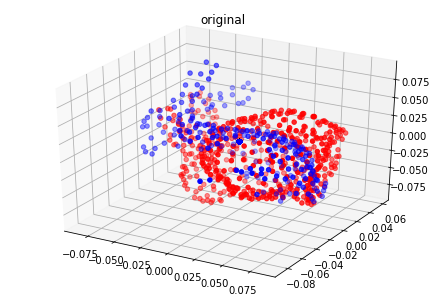

In [26]:
fig = plt.figure()
ax = Axes3D(fig)

data = rotated_frame.reshape(-1, 3)
x = data[:, 0]
y = data[:, 1]
z = data[:, 2]

ax.scatter(x, y, z, c='r', marker='o')

x_test_sample = data_pcd.reshape(-1, 3)
x = x_test_sample[:, 0]
y = x_test_sample[:, 1]
z = x_test_sample[:, 2]
ax.scatter(x, y, z, c='b', marker='o')

ax.set_title('original')
